In [1]:
import os, shutil
if os.path.exists(os.path.join(os.getcwd(),"tfdetection")):
    shutil.rmtree(os.path.join(os.getcwd(),"tfdetection"))
if os.path.exists(os.path.join(os.getcwd(),"tfdet")):
    shutil.rmtree(os.path.join(os.getcwd(),"tfdet"))
!git clone https://github.com/burf/tfdetection
shutil.copytree(os.path.join(os.getcwd(),"tfdetection", "tfdet"), os.path.join(os.getcwd(),"tfdet"))

Cloning into 'tfdetection'...
remote: Enumerating objects: 788, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 788 (delta 240), reused 276 (delta 155), pack-reused 387
Receiving objects: 100% (788/788), 8.62 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (449/449), done.


'/content/tfdet'

In [2]:
!wget -qq https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
!unzip -qq balloon_dataset.zip

import os
import json
import cv2
import skimage.draw
import tensorflow as tf
import numpy as np

def parse(path, target_size = (512, 512), method = cv2.INTER_CUBIC):
    dir_path = os.path.dirname(path)
    with open(path, "r") as file:
        anno = json.loads(file.read())
    anno = [a for a in list(anno.values()) if a["regions"]]

    images = []
    masks = []
    for a in anno:
        if type(a['regions']) is dict:
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
        else:
            polygons = [r['shape_attributes'] for r in a['regions']]
        image = cv2.cvtColor(cv2.imread(os.path.join(dir_path, a["filename"]), -1), cv2.COLOR_BGR2RGB)
        h, w = np.shape(image)[:2]
        mask = np.zeros((h, w, len(polygons)), dtype = np.uint8)
        for i, p in enumerate(polygons):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            rr = np.clip(rr, 0, h - 1)
            cc = np.clip(cc, 0, w - 1)
            mask[rr, cc, i] = 1
        
        if target_size is not None:
            image = cv2.resize(image, target_size[::-1], interpolation = method)
            mask = cv2.resize(mask, target_size[::-1], interpolation = method)
            if np.ndim(mask) == 2:
                mask = np.expand_dims(mask, axis = -1)
            mask = np.where(mask != 0, 1, 0)

        images.append(image)
        masks.append(np.transpose(mask, [2, 0, 1]))
    return images, masks

def mask2bbox(mask_true, normalize = True, decimal = 4):
    #mask_true = #(padded_num_true, h, w, 1)
    padded_num_true, h, w = np.shape(mask_true)[:3]

    bbox_true = []
    for index in range(padded_num_true):
        mask = mask_true[index]
        if 0 < np.max(mask):
            pos = np.where(0 < mask)[:2]
            bbox = [np.min(pos[1]), np.min(pos[0]), np.max(pos[1]), np.max(pos[0])] #x1, y1, x2, y2
        else:
            bbox = [0, 0, 0, 0]
        bbox_true.append(bbox)
    
    bbox_true = np.round(np.divide(bbox_true, [w, h, w, h]).astype(np.float32), decimal) if normalize else np.array(bbox_true, dtype = np.int32)
    return bbox_true

def pipe(data, func = None, batch_size = 2, shuffle = False):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    if callable(func):
        dataset = dataset.map(func, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size = batch_size * 10)
    dataset = dataset.batch(batch_size)
    #dataset = dataset.prefetch((batch_size * 2) + 1)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

tr_anno = "./balloon/train/via_region_data.json"
te_anno = "./balloon/val/via_region_data.json"

tr_x, tr_mask = parse(tr_anno, target_size = (512, 512))
te_x, te_mask = parse(te_anno, target_size = (512, 512))

max_cnt = 0
for mask in tr_mask + te_mask:
    if max_cnt < len(mask):
        max_cnt = len(mask)

tr_x = np.array(tr_x, dtype = np.float32) * 1/255
tr_mask = [np.pad(mask, [[0, max_cnt - len(mask)], [0, 0], [0, 0]]) for mask in tr_mask]
tr_mask = np.expand_dims(np.array(tr_mask, dtype = np.float32), axis = -1)
tr_bbox = np.array([mask2bbox(mask) for mask in tr_mask], dtype = np.float32)
tr_y = np.expand_dims(np.where(0 < np.max(tr_bbox, axis = -1), 1., 0.), axis = -1)

te_x = np.array(te_x, dtype = np.float32) * 1/255
te_mask = [np.pad(mask, [[0, max_cnt - len(mask)], [0, 0], [0, 0]]) for mask in te_mask]
te_mask = np.expand_dims(np.array(te_mask, dtype = np.float32), axis = -1)
te_bbox = np.array([mask2bbox(mask) for mask in te_mask], dtype = np.float32)
te_y = np.expand_dims(np.where(0 < np.max(te_bbox, axis = -1), 1., 0.), axis = -1)

In [3]:
import tfdet
import functools

x = tf.keras.layers.Input(shape = (512, 512, 3))

scale = [24, 48, 96, 192, 384]
ratio = [0.5, 1, 2]

out = tfdet.model.detector.effdet_lite_d3(x, n_class = 2, scale = scale, ratio = ratio, octave = 3)
model = tfdet.model.train.effdet.train_model(x, *out, assign = tfdet.core.assign.max_iou, sampling_count = 256, positive_ratio = 0.5)

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


In [4]:
import albumentations
method = [albumentations.RandomBrightness(0.2, p = 0.5),
          albumentations.RandomContrast(0.2, p = 0.5),
          albumentations.ChannelShuffle(p = 0.5)]
method = albumentations.Compose(method)
    
def aug_func(image):
    return method(image = image)["image"]

key = x.name
def func(dic):
    shape = tf.shape(dic[key])
    dic[key] = tf.reshape(tf.py_function(lambda *args: aug_func(args[0].numpy()), inp = [dic[key]], Tout = tf.float32), shape)
    return dic

batch_size = 2

tr_data = pipe({x.name:tr_x, "y_true":tr_y, "bbox_true":tr_bbox}, func = func, batch_size = batch_size, shuffle = True)
te_data = pipe({x.name:te_x, "y_true":te_y, "bbox_true":te_bbox}, batch_size = batch_size, shuffle = False)

In [5]:
opt = tf.keras.optimizers.SGD(5e-3, momentum = 0.9, nesterov = True)
model.compile(optimizer = opt)
model.fit(tr_data, validation_data = te_data, epochs = 100)

Epoch 1/100
31/31 [==============================] - 42s 366ms/step - loss: 1.1687 - score_accuracy: 0.5392 - score_loss: 0.1217 - regress_loss: 1.0467 - val_loss: 1.2262 - val_score_accuracy: 0.5719 - val_score_loss: 0.1219 - val_regress_loss: 1.1041
Epoch 2/100
31/31 [==============================] - 7s 212ms/step - loss: 1.1512 - score_accuracy: 0.5776 - score_loss: 0.1197 - regress_loss: 1.0313 - val_loss: 1.2224 - val_score_accuracy: 0.5523 - val_score_loss: 0.1211 - val_regress_loss: 1.1010
Epoch 3/100
31/31 [==============================] - 7s 212ms/step - loss: 1.1443 - score_accuracy: 0.6007 - score_loss: 0.1174 - regress_loss: 1.0266 - val_loss: 1.2191 - val_score_accuracy: 0.5648 - val_score_loss: 0.1203 - val_regress_loss: 1.0985
Epoch 4/100
31/31 [==============================] - 7s 211ms/step - loss: 1.1304 - score_accuracy: 0.6109 - score_loss: 0.1150 - regress_loss: 1.0151 - val_loss: 1.2160 - val_score_accuracy: 0.5621 - val_score_loss: 0.1195 - val_regress_loss: 1.

In [6]:
model.save_weights("model.h5")

In [7]:
x = tf.keras.layers.Input(shape = (512, 512, 3))
scale = [24, 48, 96, 192, 384]
ratio = [0.5, 1, 2]
out = tfdet.model.detector.effdet_lite_d3(x, n_class = 2, scale = scale, ratio = ratio)
prediction = tfdet.model.postprocess.effdet.FilterDetection(proposal_count = 100, iou_threshold = 0.3, score_threshold = 0.9, soft_nms = False)(out)
model = tf.keras.Model(x, prediction)
model.load_weights("model.h5")

In [8]:
images = te_x[:1]
logits, proposal = model.predict(images)
images = tfdet.util.draw_bbox(images, proposal, logits, label = ["Background", "Balloon"])

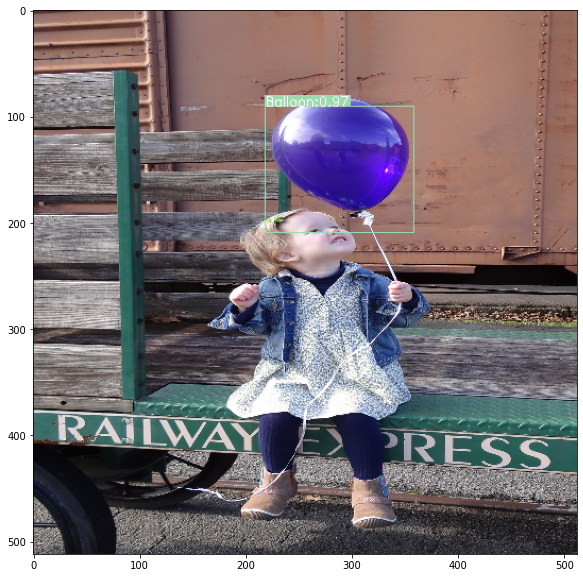

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(images[0])